## Настройки/Гиперпараметры/Импорты

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt

### 1) Очистка данных

In [20]:
data = pd.read_csv('etno_home_work.csv', sep =";")
data

,source_text,ethno
0,"[[id174199907|Мустафа], мы, украинцы и белорус...",казах
1,"Короче, я сейчас не оправдываюсь, просто хочу ...",казах
2,"[[id211685480|Заур], это связано с твоими слов...",казах
3,RT @VRSoloviev: <a href=\http://youtube.com/wa...,казах
4,Большинство монголов по крови говорят на русск...,казах
...,...,...
5571,"Руслан, если читать про аварцев то и Дудаев и ...",карачаевец
5572,"Абдулатип, у меня есть братья чеченцы , друзья...",карачаевец
5573,Да как вас узкоглазых различишь то? И на кой э...,кавказец
5574,"Интересно, а если Путин или какой-нибудь друго...",кавказец


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5576 entries, 0 to 5575
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source_text  5576 non-null   object
 1   ethno        5576 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [22]:
data.describe()

,source_text,ethno
count,5576,5576
unique,5576,178
top,"[[id146858230|Андрей], ВНЕЗАПНО в Новороссии (...",казах
freq,1,367


In [23]:
df = data.ethno.value_counts().to_frame()
df = df.reset_index()
df.columns = ['ethno', 'number of ethno']
df

,ethno,number of ethno
0,казах,367
1,азербайджанец,355
2,аварец,224
3,калмык,162
4,кавказец,154
...,...,...
173,уйгурский,1
174,евразийский_прил,1
175,дагестанский_прил,1
176,великоросский_прил,1


In [24]:
df = df.loc[df['number of ethno'] < 20]
df

,ethno,number of ethno
70,уйгур,19
71,кумык,18
72,даргинец,17
73,русак,16
74,якут,16
...,...,...
173,уйгурский,1
174,евразийский_прил,1
175,дагестанский_прил,1
176,великоросский_прил,1


In [25]:
df['ethno'].reset_index(drop=True, inplace=True)
df['ethno']

0                   уйгур
1                   кумык
2                даргинец
3                   русак
4                    якут
              ...        
103             уйгурский
104      евразийский_прил
105     дагестанский_прил
106    великоросский_прил
107        хохляцкий_прил
Name: ethno, Length: 108, dtype: object

In [26]:
for i in range(df['ethno'].shape[0]):
    data = data.loc[data['ethno'] != df['ethno'][i]]

In [27]:
data.reset_index(drop=True, inplace=True)
data

,source_text,ethno
0,"[[id174199907|Мустафа], мы, украинцы и белорус...",казах
1,"Короче, я сейчас не оправдываюсь, просто хочу ...",казах
2,"[[id211685480|Заур], это связано с твоими слов...",казах
3,RT @VRSoloviev: <a href=\http://youtube.com/wa...,казах
4,Большинство монголов по крови говорят на русск...,казах
...,...,...
4853,"Руслан, если читать про аварцев то и Дудаев и ...",карачаевец
4854,"Абдулатип, у меня есть братья чеченцы , друзья...",карачаевец
4855,Да как вас узкоглазых различишь то? И на кой э...,кавказец
4856,"Интересно, а если Путин или какой-нибудь друго...",кавказец


In [28]:
data.ethno.value_counts().to_frame()

,ethno
казах,367
азербайджанец,355
аварец,224
калмык,162
кавказец,154
...,...
мариец,21
чудь,21
аланы,20
гагауз,20


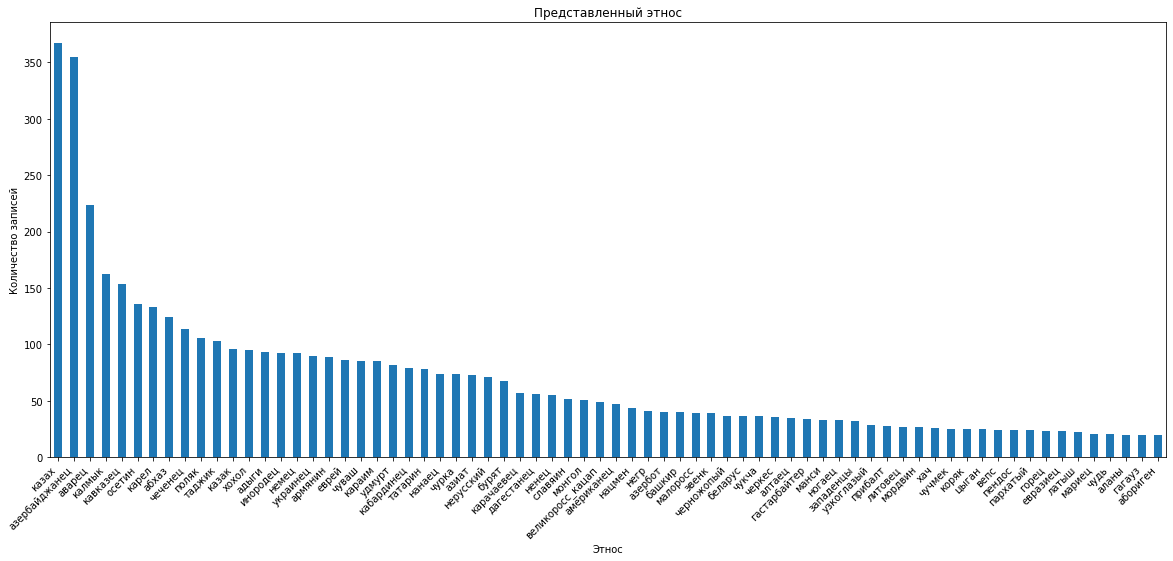

In [29]:
plt.figure(figsize=(20,8)) # задание размера графика
data["ethno"].value_counts().plot.bar() # построение столбчатой диаграммы по данным
plt.xticks(rotation=45, ha='right') # поворот на 45 градусов подписей под осью OX (ha='right' ~ правый конец соответствует колонке)
plt.title('Представленный этнос') # название графика
plt.xlabel('Этнос') # подпись по оси x
plt.ylabel('Количество записей') # подпись по оси y
plt.show() # вывод графика

In [30]:
data.isnull().sum() # проверка наличия пропущенных значений

source_text    0
ethno          0
dtype: int64

### 2) Нормализация

In [31]:
EXCLUDE_SYMBOLS_STR = u''.join(['\\', '/', '|', '.', ',', '?', '!', '(', ')', '-', '—', '_', '=', '*', '&', '"', "'", '#', ':', ';', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ']', '[', '<', '>', '»', '«', '@', '…', '+', '%']) # символы для удаления
# '$' - не удалили, так как он может нести важную информацию
regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR)) # собираем символы в формат, нужный для библиотеки re

stop_words = stopwords.words('russian')

In [32]:
data['Tokens'] = None # создание колонки под токены
for i in range(data.shape[0]): # идём по числу новостей
    text = data['source_text'][i] # взятие текста
    text = text.lower() # приводим к нижнему регистру
    text = text.replace(".com", "") # удаление окончаний ссылок
    text = regex_symb.sub(' ', text) # удаление определённых символов
    text = re.sub("[a-zA-Z]", "", text)
    
    tokens = [word.strip() for word in word_tokenize(text)] # токенизация текста (разбиение на отдельные слова + удаляем пробелы)

    tokens = [word for word in tokens if word not in stop_words] # удаление стоп-слов
    
    data['Tokens'][i] = tokens # обновление в датасете (теперь вместо текста идут токены)

In [33]:
data

,source_text,ethno,Tokens
0,"[[id174199907|Мустафа], мы, украинцы и белорус...",казах,"[мустафа, украинцы, белорусы, вышли, киевской,..."
1,"Короче, я сейчас не оправдываюсь, просто хочу ...",казах,"[короче, оправдываюсь, просто, хочу, разъяснит..."
2,"[[id211685480|Заур], это связано с твоими слов...",казах,"[заур, это, связано, твоими, словами, некой, и..."
3,RT @VRSoloviev: <a href=\http://youtube.com/wa...,казах,"[настоящие, казаки, хотя, сказать, этим, ряжен..."
4,Большинство монголов по крови говорят на русск...,казах,"[большинство, монголов, крови, говорят, русско..."
...,...,...,...
4853,"Руслан, если читать про аварцев то и Дудаев и ...",карачаевец,"[руслан, читать, аварцев, дудаев, амагов, сайт..."
4854,"Абдулатип, у меня есть братья чеченцы , друзья...",карачаевец,"[абдулатип, братья, чеченцы, друзья, дагестане..."
4855,Да как вас узкоглазых различишь то? И на кой э...,кавказец,"[узкоглазых, различишь, кой, это, нужно, гоже,..."
4856,"Интересно, а если Путин или какой-нибудь друго...",кавказец,"[интересно, путин, российский, стояк, сдаст, р..."


In [34]:
for i in range(data.shape[0]): # идём по числу новостей
    lemmatized_tokens = [WordNetLemmatizer().lemmatize(word) for word in data["Tokens"][i]] # используем лемматизатор на токенах-словах
    data["Tokens"][i] = lemmatized_tokens # заменяем токены

### 3) Векторизация

In [35]:
def dummy(tokens): # функция-заглушка для пропуска стадий препроцессинга и токенизации при векторизации (CountVectorizer и TfidfVectorizer)
   return tokens

In [36]:
count_vectorizer = CountVectorizer(tokenizer=dummy, preprocessor=dummy, max_df=0.5, min_df=25, dtype=np.int8)
# max_df - игнорируем токены, что встречаются в 50% переданных новостей
# min_df - игнорируем токены, что встретились менее 25 раз
# max_features - максимальный размер словаря, если не прокинуть — то он равен числу уникальных токенов
# dtype=np.int8 - для уменьшения потребляемой памяти, так как максимальное число встреченных одинаковых токенов в одной новости не более 48 (подсчитано на различных тестах)

vectors = count_vectorizer.fit_transform(data['Tokens']).toarray() # векторизируем, toarray() - показать матрицу

pd.DataFrame(data=vectors, columns=count_vectorizer.get_feature_names_out()) # матрица для наглядного вывода получившихся векторов новосте

c:\Users\user\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,абсолютно,абхазы,аварец,аварцев,аварцы,автор,ага,адыги,адыгов,азербайджанцев,...,являются,язык,языка,языке,языки,языком,якобы,якутов,якуты,–
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4853,0,0,0,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4854,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4855,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4856,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Определить какие 30 слов дает наибольший вклад в определение 5 наиболее представленных этничностей

In [37]:
data["ethno"].value_counts()[:5] # самые представленные этонсы

казах            367
азербайджанец    355
аварец           224
калмык           162
кавказец         154
Name: ethno, dtype: int64

In [38]:
top_presented_ethnos = data["ethno"].value_counts()[:5].keys()
top_presented_ethnos

Index(['казах', 'азербайджанец', 'аварец', 'калмык', 'кавказец'], dtype='object')

In [39]:
data_X = count_vectorizer.transform(data['Tokens']).toarray()

In [40]:
features_names = count_vectorizer.get_feature_names_out()

In [41]:
for ethno in top_presented_ethnos:
    rows_with_ethno = data.index[data['ethno'] == ethno].tolist()
    mean_for_ethno = data_X[rows_with_ethno].mean(axis=0)

    rows_without_ethno = data.index[data['ethno'] != ethno].tolist()
    mean_for_other = data_X[rows_without_ethno].mean(axis=0)

    mean_diff = mean_for_ethno - mean_for_other

    indices = np.argsort(mean_diff)[::-1]

    print(f"Для этноса '{ethno}' специфичны слова:")
    for i in range(30):
        print(f"{i+1}) {features_names[indices[i]]} ({indices[i]})")

Для этноса 'казах' специфичны слова:
1) кстати (346)
2) всё (112)
3) этих (904)
4) который (333)
5) населения (445)
6) народы (443)
7) путин (614)
8) стали (736)
9) народ (434)
10) кому (322)
11) войны (94)
12) любят (367)
13) ингушей (269)
14) народов (440)
15) те (787)
16) казаки (289)
17) племена (551)
18) н (419)
19) жили (232)
20) одни (509)
21) дагестан (155)
22) назад (421)
23) какие (296)
24) месте (383)
25) свой (684)
26) народа (435)
27) которой (329)
28) своем (679)
29) крым (341)
30) горцев (142)
Для этноса 'азербайджанец' специфичны слова:
1) русские (653)
2) сталин (737)
3) тысячи (808)
4) ненавидят (477)
5) тыс (806)
6) русских (657)
7) вообще (96)
8) россии (642)
9) крым (341)
10) часть (867)
11) татар (776)
12) основном (523)
13) русским (655)
14) дагестане (157)
15) украины (833)
16) евреи (214)
17) язык (910)
18) мало (374)
19) рф (665)
20) калмыки (304)
21) москве (414)
22) стоит (740)
23) давайте (153)
24) ненависть (479)
25) чурка (894)
26) также (768)
27) имя (26

### 4) Обучение моделей

In [42]:
data_train, data_test = train_test_split(data, test_size=0.2)
print(len(data_train), len(data_test))

3886 972


In [43]:
data_train_vect = count_vectorizer.transform(data_train["Tokens"]).toarray()
data_train_cat = data_train["ethno"]
data_test_vect = count_vectorizer.transform(data_test["Tokens"]).toarray()
data_test_cat = data_test["ethno"]

#### KNN

In [50]:
params_KNN = [{
'n_neighbors': list(range(1, 10)), # кол-во соседей
'weights': ['uniform', 'distance'], # вдияние расстояния до соседа на его вклад ("uniform" — нет влияния, "distance" — чем ближе, тем больше вклад)
'metric': ["minkowski"], # метрика для подсчёта расстояния между объектами
'p': [2], # степень в метрике Минковского расстояния (2 ~ расстояние евклидово)
'algorithm': ['auto'], # алгоритм для подсчёта ближайших соседей
}]

gs_knn = GridSearchCV( # параметры GridSearchCV
    KNeighborsClassifier(),
    params_KNN,
    verbose = 1,
    cv=3,
    n_jobs=-1,
    scoring="f1_macro"
)

gs_knn_res = gs_knn.fit(data_train_vect, data_train_cat) # подбираем лучшие параметры для оценщика
pred_knn = gs_knn_res.best_estimator_.predict(data_test_vect) # предсказываем
print(metrics.classification_report(data_test_cat, pred_knn)) # выписываем основные метрики

Fitting 3 folds for each of 18 candidates, totalling 54 fits
                  precision    recall  f1-score   support

        абориген       0.00      0.00      0.00         7
           абхаз       0.00      0.00      0.00        22
          аварец       0.05      0.11      0.07        36
           адыги       0.00      0.00      0.00        16
   азербайджанец       0.07      0.08      0.07        62
         азербот       0.00      0.00      0.00         5
           азиат       0.00      0.00      0.00        14
           аланы       0.00      0.00      0.00         9
          алтаец       0.00      0.00      0.00         7
      американец       0.00      0.00      0.00         9
         армянин       0.05      0.04      0.05        24
          башкир       0.00      0.00      0.00        11
         беларус       0.00      0.00      0.00         9
           бурят       0.00      0.00      0.00        10
великоросс_кацап       0.00      0.00      0.00         7
          

c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
print(f"Лучший score={gs_knn_res.best_score_:.4f}")

Лучший score=0.0131


#### Random Forest

In [53]:
params_RF = [{
"n_estimators": [20, 50, 100], # число деревьев в ансамбле
"criterion": ["gini", "entropy"], # критерий для оценивания качества разбиения
"max_depth": [5, 10], # лимит на максимальную глубину деревьев в ансамбле
"min_samples_split": [10, 50, 100],# минимальное число сэмплов в узле для разбиения
"max_features": ["sqrt", "log2"], # число рассматриваемых фичей ('столбцов' в датасете) при делении в узле (для best split)
"class_weight": [None, "balanced"], # балансировка весов для классов
"random_state": [42], # число для задания случайности
}]

gs_forest = GridSearchCV(
    RandomForestClassifier(),
    params_RF,
    verbose = 1,
    cv=3,
    n_jobs=-1,
    scoring="f1_macro"
)

gs_forest_res = gs_forest.fit(data_train_vect, data_train_cat)
pred_forest = gs_forest_res.best_estimator_.predict(data_test_vect)
print(metrics.classification_report(data_test_cat, pred_forest))

Fitting 3 folds for each of 144 candidates, totalling 432 fits
                  precision    recall  f1-score   support

        абориген       0.00      0.00      0.00         7
           абхаз       0.00      0.00      0.00        22
          аварец       0.00      0.00      0.00        36
           адыги       0.00      0.00      0.00        16
   азербайджанец       0.00      0.00      0.00        62
         азербот       0.00      0.00      0.00         5
           азиат       0.00      0.00      0.00        14
           аланы       0.00      0.00      0.00         9
          алтаец       0.00      0.00      0.00         7
      американец       0.00      0.00      0.00         9
         армянин       0.00      0.00      0.00        24
          башкир       0.00      0.00      0.00        11
         беларус       0.00      0.00      0.00         9
           бурят       0.10      0.10      0.10        10
великоросс_кацап       0.14      0.14      0.14         7
        

c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
print(f"Лучший score={gs_forest_res.best_score_:.4f}")

Лучший score=0.0132


#### SVM

In [57]:
params_SVM = [{
"C": [0.1, 1.0, 10.0], # параметр регуляризации; сила регуляризации обратно пропорциональна C
"kernel": ["poly"], # тип используемого ядра
"gamma": [0.001, 0.0001, "scale"], # коэффициент для ядер (‘rbf’, ‘poly’, ‘sigmoid’)
"degree": [3, 4, 5], # степень функции ядра "poly"
"class_weight": ["balanced"], # балансировка весов для классов
"random_state": [42], # число для задания случайности
},{
"C": [0.1, 1.0, 10.0], # параметр регуляризации; сила регуляризации обратно пропорциональна C
"kernel": ["linear"], # тип используемого ядра
"class_weight": ["balanced"], # балансировка весов для классов
"random_state": [42], # число для задания случайности
},{
"C": [0.1, 1.0, 10.0], # параметр регуляризации; сила регуляризации обратно пропорциональна C
"kernel": ["rbf"], # тип используемого ядра
"gamma": [0.001, 0.0001, "scale"], # коэффициент для ядер (‘rbf’, ‘poly’, ‘sigmoid’)
"class_weight": ["balanced"], # балансировка весов для классов
"random_state": [42], # число для задания случайности
}]

gs_SVM = GridSearchCV( # параметры GridSearchCV
    svm.SVC(gamma="scale"),
    params_SVM,
    verbose = 1,
    cv=3,
    n_jobs=-1,
    scoring="f1_macro"
)

gs_SVM_res = gs_SVM.fit(data_train_vect, data_train_cat) # подбираем лучшие параметры для оценщика
pred_SVM = gs_SVM_res.best_estimator_.predict(data_test_vect) # предсказываем
print(metrics.classification_report(data_test_cat, pred_SVM)) # выписываем основные метрики

Fitting 3 folds for each of 39 candidates, totalling 117 fits
                  precision    recall  f1-score   support

        абориген       0.00      0.00      0.00         7
           абхаз       0.04      0.05      0.04        22
          аварец       0.05      0.08      0.07        36
           адыги       0.05      0.06      0.05        16
   азербайджанец       0.05      0.06      0.06        62
         азербот       0.00      0.00      0.00         5
           азиат       0.06      0.07      0.06        14
           аланы       0.00      0.00      0.00         9
          алтаец       0.00      0.00      0.00         7
      американец       0.00      0.00      0.00         9
         армянин       0.11      0.04      0.06        24
          башкир       0.00      0.00      0.00        11
         беларус       0.00      0.00      0.00         9
           бурят       0.00      0.00      0.00        10
великоросс_кацап       0.12      0.14      0.13         7
         

c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
print(f"Лучший score={gs_SVM_res.best_score_:.4f}")

Лучший score=0.0176


#### Decision Tree

In [59]:
params_DT = [{
"criterion": ["gini", "entropy"], # критерий для оценивания качества разбиения
"max_depth": [10, 15, 20], # максимальная глубина дерева
"min_samples_split": [10, 50, 100], # минимальное число сэмплов в узле для разбиения
"max_features": [None, "sqrt", "log2"], # число рассматриваемых фичей ('столбцов' в датасете) при делении в узле (для best split)
"class_weight": [None, "balanced"], # балансировка весов для классов
"random_state": [42], # число для задания случайности
}]

gs_DT = GridSearchCV( # параметры GridSearchCV
    DecisionTreeClassifier(), 
    params_DT,
    verbose = 1,
    cv=3,
    n_jobs=-1,
    scoring="f1_macro"
)

gs_DT_res = gs_DT.fit(data_train_vect, data_train_cat) # подбираем лучшие параметры для оценщика
pred_DT = gs_DT_res.best_estimator_.predict(data_test_vect) # предсказываем
print(metrics.classification_report(data_test_cat, pred_DT)) # выписываем основные метрики

Fitting 3 folds for each of 108 candidates, totalling 324 fits
                  precision    recall  f1-score   support

        абориген       0.00      0.00      0.00         7
           абхаз       0.03      0.05      0.03        22
          аварец       0.01      0.03      0.02        36
           адыги       0.00      0.00      0.00        16
   азербайджанец       0.07      0.21      0.10        62
         азербот       0.00      0.00      0.00         5
           азиат       0.00      0.00      0.00        14
           аланы       0.00      0.00      0.00         9
          алтаец       0.00      0.00      0.00         7
      американец       0.00      0.00      0.00         9
         армянин       0.00      0.00      0.00        24
          башкир       0.00      0.00      0.00        11
         беларус       0.00      0.00      0.00         9
           бурят       0.00      0.00      0.00        10
великоросс_кацап       0.00      0.00      0.00         7
        

c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
data_test_vect.shape

(972, 919)

In [62]:
print(f"Лучший score={gs_DT_res.best_score_:.4f}")

Лучший score=0.0102


### Вывод

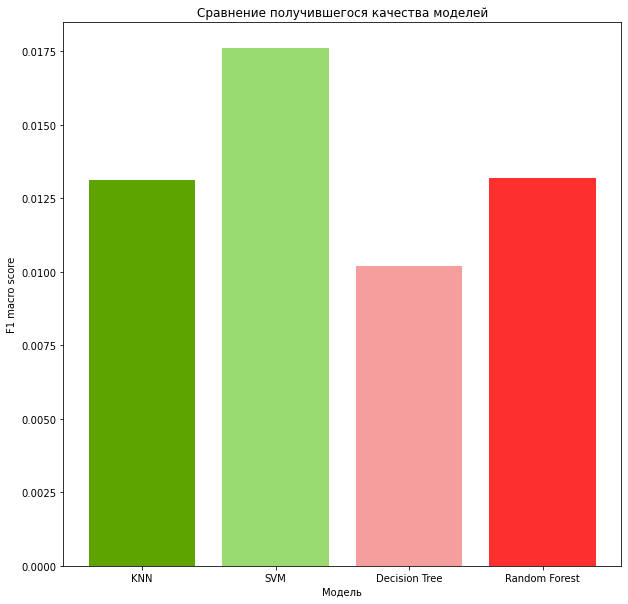

In [65]:
plt.figure(figsize=(10,10))
plt.bar(["KNN", "SVM", "Decision Tree", "Random Forest"], [0.0131, 0.0176, 0.0102, 0.0132], color=["#5da400", "#98d970", "#f69d9d", "#fe2f2f"])
plt.title('Сравнение получившегося качества моделей')
plt.xlabel('Модель')
plt.ylabel('F1 macro score')
plt.show()